**Author:** Luis Antonio Haddock III (TCF Lab)  
> **Created on:** 2022-10-25  
> **Last updated:** 2022-10-31 

**Adapted from:** https://docs.nextstrain.org/en/latest/  


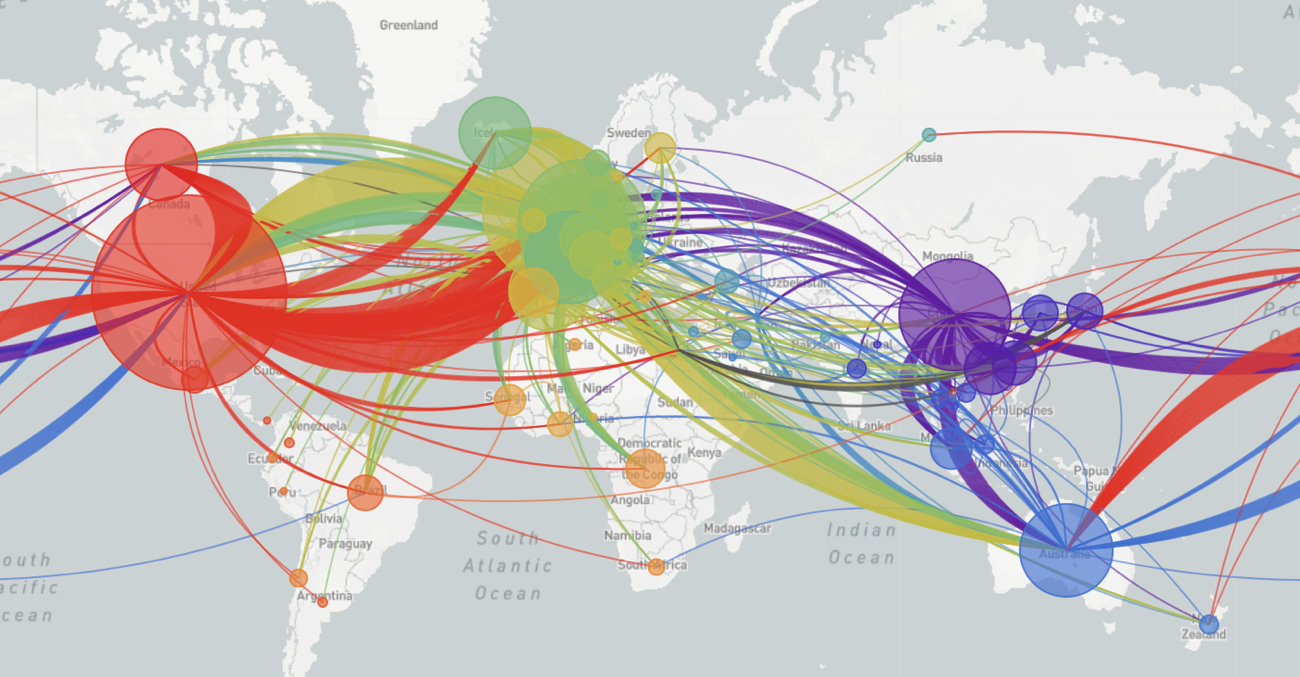

### This is an overview of how Augur works:

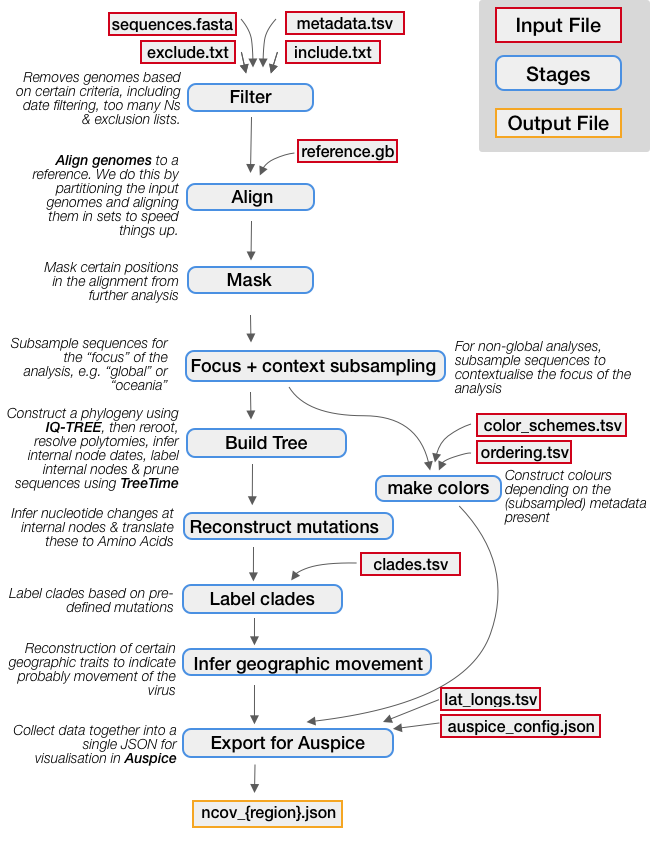

In [135]:
# Importing different modules (we might not use all of them)
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import pyplot
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl
from pandas.plotting import table
import seaborn as sns
from scipy import stats
from statistics import mean
from scipy.integrate import quad
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import csv
from pathlib import Path
import numpy as np
import json
import requests
import datetime
from Bio import SeqIO
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Structure of input files

> 1. Fasta sequenes in a `sequences.fa` file
> 2. Metadata in a `metadata.tsv` file containing at least the following columns:
>> a. name/strain  
>> b. date of collection  
>> c. Country, Region, and Division  
>> d. pangolin Lineage  


If obtinaing sequences from GISAID, there is an option of downloading htem as `Augur impit files`, which will contain both the fasta sequences and metadata for each in the same directory.


### Getting Nextstrain's environment to work with Jupyter (only if using jupyter notebook)

   1. Activated my environment with `conda activate nextstrain`
   2. Installed IpyKernel with `conda install ipykernel`
   3. Registered Nextstrain as an environment with `ipython kernel install --user --name=nextstrain`
   4. To unregister use `jupyter kernelspec uninstall nextstrain`



## Root-To-Tip analysis using Nextstrain's Augur pipeline 
### Will use both B.1.234 and Omicron squences

Using Midwest states: llinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Missouri, Nebraska, North Dakota, Ohio, South Dakota, Wisconsin

In [2]:
%%bash

# If we have multiple fasta files, we need to concatenate them all 
# into a single file 

cat path_to_augur_download/*.fasta > gisaid_downloads/dataset_sequences.fasta

In [7]:
#concatenate all files into a single dataframe
folder='path_to_augur_download'
all_files = glob.glob(os.path.join(folder, "*.tsv")) 
df_from_each_file = (pd.read_csv(f, sep='\t') for f in all_files)
concatenated_df = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df.to_csv('gisaid_downloads/metadata.tsv', sep='\t', index=False)

In [144]:
# We are adding a column with WHO assignments for the pango lineages

df = pd.read_csv('gisaid_downloads/metadata.tsv', sep='\t')

df.loc[df['pangolin_lineage'] == "B.1.1.7", 'WHO_class'] = 'Alpha'
df.loc[df['pangolin_lineage'] == "B.1.351", 'WHO_class'] = 'Beta'
df.loc[df['pangolin_lineage'] == "P.1", 'WHO_class'] = 'Gamma'
df.loc[df['pangolin_lineage'] == "B.1.617.2", 'WHO_class'] = 'Delta'
df.loc[df['pangolin_lineage'].str.startswith('AY'), 'WHO_class'] = 'Delta'
df.loc[df['pangolin_lineage'].str.startswith('B.1.42'), 'WHO_class'] = 'Epsilon'
df.loc[df['pangolin_lineage'] == "B.1.525", 'WHO_class'] = 'Eta'
df.loc[df['pangolin_lineage'] == "B.1.526", 'WHO_class'] = 'Iota'
df.loc[df['pangolin_lineage'] == "B.617.1", 'WHO_class'] = 'Kappa'
df.loc[df['pangolin_lineage'].str.startswith('B.1.621'), 'WHO_class'] = 'Mu'
df.loc[df['pangolin_lineage'] == "P.2", 'WHO_class'] = 'Zeta'
df.loc[df['pangolin_lineage'] == "B.1.1.529", 'WHO_class'] = 'Omicron'
df.loc[df['pangolin_lineage'].str.startswith('B.1.234'), 'WHO_class'] = 'B.1.234'
df.loc[df['pangolin_lineage'].str.startswith('BA.1'), 'WHO_class'] = 'Omicron BA.1'
df.loc[df['pangolin_lineage'].str.startswith('BA.2'), 'WHO_class'] = 'Omicron BA.2'
df.loc[df['pangolin_lineage'].str.startswith('BA.3'), 'WHO_class'] = 'Omicron BA.3'
df.loc[df['pangolin_lineage'].str.startswith('BA.4'), 'WHO_class'] = 'Omicron BA.4'
df.loc[df['pangolin_lineage'].str.startswith('BA.5'), 'WHO_class'] = 'Omicron BA.5'
df.loc[df['pangolin_lineage'].str.startswith('BA.6'), 'WHO_class'] = 'Omicron BA.6'
df.loc[df['pangolin_lineage'].str.startswith('BF'), 'WHO_class'] = 'Omicron (other)'
df.loc[df['pangolin_lineage'].str.startswith('BE'), 'WHO_class'] = 'Omicron (other)'
df.loc[df['pangolin_lineage'].str.startswith('BG'), 'WHO_class'] = 'Omicron (other)'
df.loc[df['pangolin_lineage'].str.startswith('X'), 'WHO_class'] = 'Recombinant'
df.loc[df['pangolin_lineage'].str.startswith('Unass'), 'WHO_class'] = 'Unassigned'
df['WHO_class'] = df['WHO_class'].fillna("Other")
#df = df.rename(columns={'strain': 'strain'})
print(('length before dropping repeated sequences',len(df)))
df_dropped = df.drop_duplicates(subset='strain', keep="first") 
print('length after dropping repeated sequences',len(df_dropped))

df_dropped.to_csv('gisaid_downloads/dataset_sequences.tsv', sep='\t', index=False)


9617
9585


In [21]:
#saving a cvs with dates in case we need it later
df = df[['strain', 'date']]
df = df.copy()
df['date'] = pd.to_datetime(df['date'])
df.info()
df.to_csv('resources/dates.txt', sep='\t', header=False, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9617 entries, 0 to 9616
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   strain  9617 non-null   object        
 1   date    9617 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 150.4+ KB


In [14]:
!mkdir resources
date_only = df_dropped[['strain','date']]
date_only['date'] = date_only['date'].astype('str')
missing_complete_date = date_only.query("date.str.len() < 10", engine="python")
missing_complete_date = missing_complete_date['strain']
missing_complete_date.to_csv('resources/missing_complete_dates.txt', sep='\t', header=False, index=False)

epi_id = df_dropped[['gisaid_epi_isl']]
epi_id.to_csv('resources/epi_list_id_complete_dataset.txt', sep='\t', header=False, index=False)


mkdir: resources: File exists


/var/folders/4h/6r4ld7rx7696y7ff000141z40000gp/T/ipykernel_66175/2027086150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_only['date'] = date_only['date'].astype('str')


In [15]:
%%bash

# the next set of rules will work to export the necesary files to run Auspice and visualzie phylogenies

# If you are using the teminal, you have to work inside the directory with the metadata and fasta files
# otherwise you will have to redirect the commands to the appropriate directories. If usung jupyter notebook, 
# simply create/open theis notebook in the same location of your fasta and metadta files.

# First, we need to index our sequences using `augur index`. This will generate a tsv file that will have
# the numbers of nucleotides, gaps, invalid characters, and sequence length for each sample before filtering
mkdir augur_results

augur index \
    --sequences gisaid_downloads/dataset_sequences.fasta \
    --output augur_results/sequence_index.tsv
    



In [20]:
%%bash

augur filter \
    --sequences gisaid_downloads/dataset_sequences.fasta \
    --metadata gisaid_downloads/dataset_sequences.tsv \
    --metadata-id-columns 'strain' \
    --group-by 'division' \
    --include resources/seq_to_include.txt \
    --exclude-ambiguous-dates-by 'any' \
    --sequences-per-group 50 \
    --sequence-index augur_results/sequence_index.tsv \
    --output augur_results/fasta_sequences_filtered.fasta
    
    
#        --subsample-max-sequences 800 \

9110 strains were dropped during filtering
	8 of these were dropped because of their ambiguous date in any
	1 strains were added back because they were in resources/seq_to_include.txt
	9103 of these were dropped because of subsampling criteria
475 strains passed all filters


In [22]:
%%bash

# MSA

augur align \
    --sequences augur_results/fasta_sequences_filtered.fasta \
    --reference-name 'hCoV-19/USA/MN-Mayo-1330/2020' \
    --output augur_results/fasta_sequences_aligned_2.fasta

# We used hCoV-19/USA/MN-Mayo-1330/2020 as the reference, but it can be changed to any other sequence


using mafft to align via:
	mafft --reorder --anysymbol --nomemsave --adjustdirection --thread 1 augur_results/wi_sequences_aligned_2.fasta.to_align.fasta 1> augur_results/wi_sequences_aligned_2.fasta 2> augur_results/wi_sequences_aligned_2.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436

43bp insertion at ref position 0
	TATACCTTCCCAGGTAACAAACCAACCA: hCoV-19/USA/WI-WSLH-2206007/2022, hCoV-19/USA/MN-Mayo-10605/2020, hCoV-19/USA/IA-SHL-1604510/2021
	TTCCCAGGTAACAAACCAACCA: hCoV-19/USA/IA-SHL-1423996/2020, hCoV-19/USA/OH-ODH-SC1029115/2021
	ATACCTTCCCAGGTAACAAACCAACCA: hCoV-19/USA/KS-CDC-ASC210000371/2021, hCoV-19/USA/IA-SHL-1591574/2021, hCoV-19/USA/MI-MDHHS-SC25188/2021
	CAACCA: hCoV-19/USA/MN-Mayo-14899/2020
	A: hCoV-19/USA/MN-Mayo-11598/2020, hCoV-19/USA/MN-Mayo-12224/2020, hCoV-19/USA/MN-Mayo7752/2020, hCoV-19/USA/MN-Mayo-11994/2020, hCoV-19/USA/IA-Mayo22418/2020, hCoV-19/USA/MN-Mayo-12526/2020, hCoV-19/USA/KS-KHEL-0736/2020,

	AGCTTCTTACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA: hCoV-19/USA/MN-Mayo-10605/2020, hCoV-19/USA/OH-CDC-ASC210000581/2021
	AGCTTCT: hCoV-19/USA/MN-Mayo-12866/2020, hCoV-19/USA/MO-CDC-ASC210000499/2021
	AG: hCoV-19/USA/MN-Mayo-12526/2020, hCoV-19/USA/MN-Mayo8482/2020, hCoV-19/USA/OH-CDC-STM-000004168/2021
	AGCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA: hCoV-19/USA/MO-MSPHL-000526/2020
	AGCTTCTTAG: hCoV-19/USA/KS-KHEL-0270/2020, hCoV-19/USA/OH-21AM-026CO04396/2021, hCoV-19/USA/OH-21AM-096CO06955/2021, hCoV-19/USA/KS-MAWD-7093230.A/2021, hCoV-19/USA/OH-21AM-019CO02339/2021, hCoV-19/USA/OH-21AM-021CO00115/2021
	AGCTTCTTAGGAGAATGACA: hCoV-19/USA/KS-KHEL-0264/2020, hCoV-19/USA/IN-CDC-2-3769265/2020
	A: hCoV-19/USA/NE-CDC-2-3992497/2021, hCoV-19/USA/ND-NDDH-0090/2020, hCoV-19/USA/IA-CDC-2-3845912/2021
	AGCTTCTTAGGAGAATGAC: hCoV-19/USA/IA-CDC-2-3881101/2021, hCoV-19/USA/NE-CDC-2-4069010/2021, hCoV-19/USA/OH-CDC-2-3845343/2021, hCoV-19/USA/NE-CDC-2-4058365/2021, hCoV-19/USA/IA-CDC-2-4069008/2021, hCoV-19/USA/IA-C

In [23]:
%%bash
echo 'Making sure there are no duplicated sequences'
seqkit rmdup -n augur_results/fasta_sequences_aligned_2.fasta > augur_results/fasta_sequences_aligned.fasta

[INFO] 0 duplicated records removed


In [24]:
# Storing all fasta headers in a list using a function

def sequence_extract_fasta(fasta_files):
    fasta_id = []
    fasta_seq = []

    # opening given fasta file using the file path
    with open(fasta_files, 'r') as fasta_file:
        # extracting multiple data in single fasta file using biopython
        for record in SeqIO.parse(fasta_file, 'fasta'):  # (file handle, file format)
        
            # appending extracted fasta data to empty lists variables
            fasta_seq.append(record.seq)
            fasta_id.append(record.id)
    return fasta_id#, fatsa_seq


sequences = sequence_extract_fasta('augur_results/fasta_sequences_filtered.fasta')

#list of fasta ID's from the filtered file will be saved in the variable "sequences"

In [25]:
%%bash

# We have completed the alignment, so now we can start constructing a phylogeny and 
# configure the file to label the tips according to specific criteria

# First we infer a phylogeny in the form of a newik file using either FastTree, Raxml, iqtree (default)

augur tree \
    --alignment augur_results/fasta_sequences_aligned.fasta \
    --output augur_results/fasta_sequences_tree_raw.nwk

# The resulting tree is stored in Newick format. Branch lengths in this tree measure nucleotide divergence, 
# the moment of splitting apart of a single group into two descendant groups.
# Newick format is a tree representation using nested parentheses


# We can use `augur refine` to adjust branch lengths. This will position tips by their sample date and infer 
# the most likely time of their ancestors using TreeTime. The output will be stored in a json format and it 
# will contain brang lengths. We need the metadata containing collection dates to infer this



Building a tree via:
	iqtree2 -nt 1 -s augur_results/wi_sequences_aligned-delim.fasta -m GTR -ninit 2 -n 2 -me 0.05 > augur_results/wi_sequences_aligned-delim.iqtree.log
	Nguyen et al: IQ-TREE: A fast and effective stochastic algorithm for estimating maximum likelihood phylogenies.
	Mol. Biol. Evol., 32:268-274. https://doi.org/10.1093/molbev/msu300


Building original tree took 17.734131813049316 seconds


In [26]:
%%bash

augur refine \
    --tree augur_results/fasta_sequences_tree_raw.nwk \
    --alignment augur_results/fasta_sequences_aligned.fasta \
    --metadata gisaid_downloads/dataset_sequences.tsv \
    --output-tree augur_results/fasta_sequences_tree_refined.nwk \
    --output-node-data augur_results/fasta_sequences_branch_lengths.json \
    --timetree \
    --root 'least-squares' \
    --coalescent opt \
    --date-confidence \
    --date-inference marginal 
#    --clock-filter-iqd 4
  
#    --coalescent opt \
# In addition to assigning times to internal nodes, the refine command filters tips that are likely 
# outliers and assigns confidence intervals to inferred dates. Branch lengths in the resulting Newick 
# tree measure adjusted nucleotide divergence. All other data inferred by TreeTime is stored by strain 
# or internal node name in the corresponding JSON file.

# Do not have anything after the "\" like spaces or comments






augur refine is using TreeTime version 0.9.3

8.97	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

14.03	TreeTime.reroot: with method or node: least-squares

14.03	TreeTime.reroot: rerooting will account for covariance and shared
     	ancestry.

18.70	###TreeTime.run: INITIAL ROUND

33.47	TreeTime.reroot: with method or node: least-squares

33.47	TreeTime.reroot: rerooting will account for covariance and shared
     	ancestry.

34.34	###TreeTime.run: rerunning timetree after rerooting

51.05	###TreeTime.run: ITERATION 1 out of 2 iterations

74.06	###TreeTime.run: ITERATION 2 out of 2 iterations

154.39	###TreeTime.run: FINAL ROUND - confidence estimation via marginal
   

In [27]:
%%bash

# With Augur, we can reconstruct and infer ancestral traits, as well as get amino acid mutations

# Reconstructing ancestral traits using `augur traits`. This will create a json file with this data


augur traits \
    --tree augur_results/fasta_sequences_tree_refined.nwk \
    --metadata gisaid_downloads/dataset_sequences.tsv \
    --output-node-data augur_results/fasta_sequences_traits.json \
    --confidence \
    --columns pangolin_lineage WHO_class division

augur traits is using TreeTime version 0.9.3
Assigned discrete traits to 475 out of 475 taxa.

NOTE: previous versions (<0.7.0) of this command made a 'short-branch
length assumption. TreeTime now optimizes the overall rate numerically
and thus allows for long branches along which multiple changes
accumulated. This is expected to affect estimates of the overall rate
while leaving the relative rates mostly unchanged.
Assigned discrete traits to 475 out of 475 taxa.

NOTE: previous versions (<0.7.0) of this command made a 'short-branch
length assumption. TreeTime now optimizes the overall rate numerically
and thus allows for long branches along which multiple changes
accumulated. This is expected to affect estimates of the overall rate
while leaving the relative rates mostly unchanged.
Assigned discrete traits to 475 out of 475 taxa.

NOTE: previous versions (<0.7.0) of this command made a 'short-branch
length assumption. TreeTime now optimizes the overall rate numerically
and thus allow

In [28]:
%%bash

# Next, infer the ancestral sequence of each internal node and identify any nucleotide mutations 
# on the branches leading to any node in the tree.


augur ancestral \
    --tree augur_results/fasta_sequences_tree_refined.nwk \
    --alignment augur_results/fasta_sequences_aligned.fasta \
    --output-node-data augur_results/fasta_sequences_nt_muts.json \
    --inference joint 

#calculate joint or marginal maximum likelihood ancestral sequence states
    
    

augur ancestral is using TreeTime version 0.9.3

Inferred ancestral sequence states using TreeTime:
	Sagulenko et al. TreeTime: Maximum-likelihood phylodynamic analysis
	Virus Evolution, vol 4, https://academic.oup.com/ve/article/4/1/vex042/4794731

ancestral mutations written to augur_results/wi_sequences_nt_muts.json


In [31]:
%%bash

# exporting...

augur export v2 \
    --tree augur_results/fasta_sequences_tree_refined.nwk \
    --metadata gisaid_downloads/dataset_sequences.tsv \
    --node-data augur_results/fasta_sequences_branch_lengths.json augur_results/fasta_sequences_nt_muts.json augur_results/fasta_sequences_traits.json \
    --colors resources/color.txt \
    --maintainers Your_Name_Here \
    --lat-longs resources/lat_long.tsv \
    --auspice-config resources/auspice_config.json \
    --output augur_results/fasta_sequences_auspice.json


# The most important file is the  [--output] fasta_sequences_auspice.json, which is the tree that will 
# be opened using Auspice.

#to run auspice, you have to install it using conda

    #https://docs.nextstrain.org/projects/auspice/en/stable/introduction/install.html

#and then run the following

    #auspice view --datasettDir name_of_directory_containing_the_json_file


#there will be a message displayed in the terminal like the one below

#```
#---------------------------------------------------
#Auspice server now running at http://localhost:4000
#Serving auspice version 2.37.0
#Looking for datasets in /Users/labadmin/Documents/omicron_analysis/uw_samples_sequences/dataset_auspice
#Looking for narratives in /Users/labadmin/scripts/auspice/narratives
#---------------------------------------------------#

#```

# simply copy the link (http://localhost:4000) and paste it into your browser.

	b.1.234.
	Auspice will create colors for them.











		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in

Validating schema of 'augur_results/wi_sequences_nt_muts.json'...
Validating config file resources/auspice_config.json against the JSON schema
Validating schema of 'resources/auspice_config.json'...
Validating produced JSON
Validating schema of 'augur_results/wi_sequences_auspice.json'...
Validating that the JSON is internally consistent...
Validation of 'augur_results/wi_sequences_auspice.json' succeeded, but there were warnings you may want to resolve.



In [32]:
data = pd.read_csv('gisaid_downloads/dataset_sequences.tsv', sep='\t')
data = data[['strain','date']]
data.to_csv('gisaid_downloads/name_date_list.csv', sep=',')


In [33]:
%%R
library(lubridate)


data <- read.csv('gisaid_downloads/name_date_list.csv', sep=',')

data$date <- ymd(data$date)

data$date <- decimal_date(data$date)

data <- data[c('strain', 'date')]
  
write.csv(data, "resources/dates_decimal.csv", row.names = TRUE)



R[write to console]: 
Attaching package: ‘lubridate’


R[write to console]: The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [36]:
dec = pd.read_csv('resources/dates_decimal.csv')
print(dec['date'].min())
print(dec['date'].max())
dec = dec[['strain', 'date']]
dec.to_csv('resources/dates_decimal.csv', sep=',')
dec

2020.38797814208
2022.6602739726


,strain,date
0,hCoV-19/USA/WI-UW-10932/2022,2022.339726
1,hCoV-19/USA/WI-CDC-LC0638972/2022,2022.350685
2,hCoV-19/USA/WI-Curative-371283/2022,2022.350685
3,hCoV-19/USA/WI-MHDL-2022050416/2022,2022.342466
4,hCoV-19/USA/WI-WSLH-2205197/2022,2022.356164
...,...,...
9580,hCoV-19/USA/WI-MHDL-2022080816/2022,2022.523288
9581,hCoV-19/USA/WI-MHDL-2022080817/2022,2022.523288
9582,hCoV-19/USA/WI-MHDL-2022080818/2022,2022.526027
9583,hCoV-19/USA/WI-RVTN-602801001/2022,2022.550685


## RTT using TreeTime

In [39]:
%%bash

treetime clock \
--tree augur_results/fasta_sequences_tree_raw.nwk \
--aln augur_results/fasta_sequences_aligned.fasta \
--dates resources/dates_decimal.csv \
--name-column "strain" \
--date-column "date" \
--clock-filter 3 \
--reroot 'oldest' \
--outdir augur_results/root_to_tip_all \
--covariation 


0.00	-TreeAnc: set-up

Attempting to parse dates...
	Using column 'strain' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.

8.47	TreeTime.reroot: with method or node: oldest

8.77	TreeTime.reroot: with method or node: oldest
The following leaves don't follow a loose clock and will be ignored in rate estimation:
	hCoV-19/USA/NE-CUMC_21004228/2021

9.00	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

13.50	TreeTime.reroot: with method or node: least-squares

13.50	TreeTime.reroot: rerooting will account for covariance and shared
     	ancestry.

17.37	###TreeTime.run: INITIAL ROUND

31.13	TreeTime: the following tips have been marked a

In [40]:
#Adding divergence info to metadata file

rtt = pd.read_csv('augur_results/root_to_tip_all/rtt.csv', skiprows=1)

rtt = rtt.rename(columns={'name': 'strain'})

#reading full metadata
df = pd.read_csv('gisaid_downloads/dataset_sequences.tsv', sep='\t')

df = df[['strain','date','country', 'division', 'location','length',
       'age', 'sex', 'pangolin_lineage', 'WHO_class']]
df.loc[df['WHO_class'].str.startswith('Omicron'), 'lineage_class'] = 'Omicron'
df.loc[df['WHO_class'].str.startswith('B.1.234'), 'lineage_class'] = 'B.1.234'
data_combined = pd.merge(rtt, df, on='strain')

data_combined.to_csv('augur_results/root-to-tip_all_complete.tsv', sep=',')
data_combined.head(2)



,strain,date,root-to-tip distance,clock-deviation,date,country,division,location,length,age,sex,pangolin_lineage,WHO_class,lineage_class
0,hCoV-19/USA/MN-Mayo-1330/2020,2020.387978,0.000117,0.000025,2020-05-22,USA,Minnesota,Stearns County,29813,28,Male,B.1.234,B.1.234,B.1.234
1,hCoV-19/USA/NE-CUMC_20356295/2020,2020.937158,0.000218,-0.000189,2020-12-09,USA,Nebraska,NaN,29644,unknown,unknown,B.1.234,B.1.234,B.1.234
2,hCoV-19/USA/NE-CDC-LC0004743/2021,2021.008219,0.000185,-0.000262,2021-01-04,USA,Nebraska,NaN,29713,unknown,Male,B.1.234,B.1.234,B.1.234
3,hCoV-19/USA/NE-COPH-A1M4TCW/2020,2020.860656,0.000184,-0.000179,2020-11-11,USA,Nebraska,NaN,29540,unknown,unknown,B.1.234,B.1.234,B.1.234
4,hCoV-19/USA/ND-NDDH-0071/2021,2021.027397,0.000251,-0.000207,2021-01-11,USA,North Dakota,NaN,29865,unknown,unknown,B.1.234,B.1.234,B.1.234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,hCoV-19/USA/NE-COPH-A15Z3HQ/2020,2020.857923,0.000384,0.000023,2020-11-10,USA,Nebraska,NaN,29540,unknown,unknown,B.1.234,B.1.234,B.1.234
471,hCoV-19/USA/ND-NDDH-0090/2020,2020.877049,0.000619,0.000247,2020-11-17,USA,North Dakota,NaN,29814,unknown,unknown,B.1.234,B.1.234,B.1.234
472,hCoV-19/USA/NE-COPH-A1GAHCX/2020,2020.860656,0.000418,0.000055,2020-11-11,USA,Nebraska,NaN,29540,unknown,unknown,B.1.234,B.1.234,B.1.234
473,hCoV-19/USA/NE-COPH-A15ZDHP/2020,2020.857923,0.000384,0.000023,2020-11-10,USA,Nebraska,NaN,29540,unknown,unknown,B.1.234,B.1.234,B.1.234


## Root-To-Tip analysis using Nextstrain's Augur pipeline 
### Only for B.1.234 squences

Using Midwest states: llinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Missouri, Nebraska, North Dakota, Ohio, South Dakota, Wisconsin

In [43]:
df = pd.read_csv('gisaid_downloads/dataset_sequences.tsv', sep='\t')

df = df[df['WHO_class']== 'B.1.234']
df.head(2)

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,location,region_exposure,...,GISAID_clade,originating_lab,submitting_lab,authors,url,title,paper_url,date_submitted,purpose_of_sequencing,WHO_class
6318,hCoV-19/USA/WI-GMF-45346/2020,betacoronavirus,EPI_ISL_942765,?,2020-12-29,North America,USA,Wisconsin,Monroe County,North America,...,G,Gundersen Molecular Diagnostics Laboratory,Kabara Cancer Research Institute,"Craig S. Richmond, Paraic A. Kenny",https://www.gisaid.org/,?,?,2021-02-05,?,B.1.234
6319,hCoV-19/USA/MI-UM-10038392469/2021,betacoronavirus,EPI_ISL_1200966,?,2021-02-18,North America,USA,Michigan,NaN,North America,...,G,University of Michigan Clinical Microbiology L...,"Lauring Lab, University of Michigan, Departmen...",Valesano,https://www.gisaid.org/,?,?,2021-03-10,?,B.1.234


In [ ]:
date_only = df[['strain','date']]
date_only['date'] = date_only['date'].astype('str')
missing_complete_date = date_only.query("date.str.len() < 10", engine="python")
missing_complete_date = missing_complete_date['strain']
missing_complete_date.to_csv('resources/missing_complete_dates.txt', sep='\t', header=False, index=False)



In [47]:
# Getting list of sequences from original document

def sequence_extract_fasta(fasta_files):
    fasta_id = []
    fasta_seq = []

    # opening given fasta file using the file path
    with open(fasta_files, 'r') as fasta_file:
        # extracting multiple data in single fasta file using biopython
        for record in SeqIO.parse(fasta_file, 'fasta'):  # (file handle, file format)
        
            # appending extracted fasta data to empty lists variables
            fasta_seq.append(record.seq)
            fasta_id.append(record.id)
    return fasta_id#, fatsa_seq


sequences = sequence_extract_fasta('augur_results/fasta_sequences_filtered.fasta')

#list of fasta ID's from the filtered file will be saved in the variable "sequences"
sequences

['hCoV-19/USA/WI-UW-11574/2022',
 'hCoV-19/USA/WI-MCRI-009774/2022',
 'hCoV-19/USA/WI-MCRI-009568/2022',
 'hCoV-19/USA/WI-MCRI-009579/2022',
 'hCoV-19/USA/WI-CDC-LC0716456/2022',
 'hCoV-19/USA/WI-MCRI-010051/2022',
 'hCoV-19/USA/WI-MHDL-2022060751/2022',
 'hCoV-19/USA/WI-MHDL-2022060820/2022',
 'hCoV-19/USA/WI-MHDL-2022060880/2022',
 'hCoV-19/USA/WI-MCRI-009912/2022',
 'hCoV-19/USA/WI-WSLH-2205896/2022',
 'hCoV-19/USA/WI-UW-12203/2022',
 'hCoV-19/USA/WI-WSLH-2206007/2022',
 'hCoV-19/USA/WI-UW-12401/2022',
 'hCoV-19/USA/WI-MHDL-2022070374/2022',
 'hCoV-19/USA/WI-CDC-QDX39124561/2022',
 'hCoV-19/USA/WI-CDC-QDX38923239/2022',
 'hCoV-19/USA/WI-CDC-LC0800394/2022',
 'hCoV-19/USA/WI-MHDL-2022080105/2022',
 'hCoV-19/USA/WI-MHDL-2022080321/2022',
 'hCoV-19/USA/WI-MHDL-2022080357/2022',
 'hCoV-19/USA/WI-CDC-LC0826158/2022',
 'hCoV-19/USA/WI-CDC-LC0826246/2022',
 'hCoV-19/USA/WI-CDC-LC0832811/2022',
 'hCoV-19/USA/WI-CDC-QDX40273089/2022',
 'hCoV-19/USA/WI-CDC-QDX40374044/2022',
 'hCoV-19/USA/WI-

In [49]:
sequences = pd.DataFrame(sequences)
sequences = sequences.rename(columns={0:'strain'})
merged_df = pd.merge(sequences, df, on='strain')
merged_df.head(2)

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,location,region_exposure,...,GISAID_clade,originating_lab,submitting_lab,authors,url,title,paper_url,date_submitted,purpose_of_sequencing,WHO_class
0,hCoV-19/USA/MI-UM-10038408034/2021,betacoronavirus,EPI_ISL_1200967,?,2021-02-19,North America,USA,Michigan,NaN,North America,...,G,University of Michigan Clinical Microbiology L...,"Lauring Lab, University of Michigan, Departmen...",Valesano,https://www.gisaid.org/,?,?,2021-03-10,?,B.1.234
1,hCoV-19/USA/KS-CDC-LC0000321/2020,betacoronavirus,EPI_ISL_1028067,?,2020-12-26,North America,USA,Kansas,NaN,North America,...,G,Laboratory Corporation of America,"Respiratory Viruses Branch, Division of Viral ...","Peter W. Cook, Dakota Howard, Dhwani Batra, Be...",https://www.gisaid.org/,?,?,2021-02-18,?,B.1.234


In [51]:
#saving a cvs with strain names
df = merged_df[['strain']]
df = df.copy()
df.info()
df.to_csv('resources/b1234_strains_included.txt', sep='\t', header=False, index=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 0 to 425
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   strain  426 non-null    object
dtypes: object(1)
memory usage: 6.7+ KB


In [52]:
%%bash

augur filter \
    --sequences gisaid_downloads/dataset_sequences.fasta \
    --metadata gisaid_downloads/dataset_sequences.tsv \
    --metadata-id-columns 'strain' \
    --exclude-all \
    --include resources/b1234_strains_included.txt resources/seq_to_include.txt \
    --sequence-index augur_results/sequence_index.tsv \
    --output augur_results/b1234_sequences_filtered.fasta
    
    
#        --subsample-max-sequences 800 \

9159 strains were dropped during filtering
	9585 of these were dropped by `--exclude-all`
	426 strains were added back because they were in resources/b1234_strains_included.txt
	1 strains were added back because they were in resources/seq_to_include.txt
426 strains passed all filters


In [53]:
%%bash

# MSA

augur align \
    --sequences augur_results/b1234_sequences_filtered.fasta \
    --reference-name 'hCoV-19/USA/MN-Mayo-1330/2020' \
    --output augur_results/b1234_sequences_aligned_2.fasta





using mafft to align via:
	mafft --reorder --anysymbol --nomemsave --adjustdirection --thread 1 augur_results/b1234_sequences_aligned_2.fasta.to_align.fasta 1> augur_results/b1234_sequences_aligned_2.fasta 2> augur_results/b1234_sequences_aligned_2.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436

43bp insertion at ref position 0
	TTCCCAGGTAACAAACCAACCA: hCoV-19/USA/IA-SHL-1423996/2020, hCoV-19/USA/OH-ODH-SC1029115/2021
	ATACCTTCCCAGGTAACAAACCAACCA: hCoV-19/USA/KS-CDC-ASC210000371/2021, hCoV-19/USA/IA-SHL-1591574/2021, hCoV-19/USA/MI-MDHHS-SC25188/2021
	CAACCA: hCoV-19/USA/MN-Mayo-14899/2020
	A: hCoV-19/USA/MN-Mayo-11598/2020, hCoV-19/USA/MN-Mayo-12224/2020, hCoV-19/USA/MN-Mayo7752/2020, hCoV-19/USA/MN-Mayo-11994/2020, hCoV-19/USA/IA-Mayo22418/2020, hCoV-19/USA/MN-Mayo-12526/2020, hCoV-19/USA/KS-KHEL-0736/2020, hCoV-19/USA/MO-CDC-ASC210000499/2021, hCoV-19/USA/MN-Mayo7030/2020, hCoV-19/USA/ND-NDDH-0150/2021, hCoV-19/USA/IN-CDC-S

	AGCTTCTTAGGAGAATGACAAAAA: hCoV-19/USA/KS-CDC-2-4310014/2021
	AGCTGAGAA: hCoV-19/USA/MN-Mayo5651/2020
	AGCTTACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA: hCoV-19/USA/IA-CDC-ASC210041549/2021
	AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA: hCoV-19/USA/ND-NDDH-01739/2021, hCoV-19/USA/ND-NDDH-0799/2021, hCoV-19/USA/ND-NDDH-0150/2021, hCoV-19/USA/ND-NDDH-02630/2021, hCoV-19/USA/ND-NDDH-0625/2021, hCoV-19/USA/ND-NDDH-0644/2021, hCoV-19/USA/ND-NDDH-0311/2021, hCoV-19/USA/ND-NDDH-0073/2021, hCoV-19/USA/ND-NDDH-0278/2020
	AGCTTCTTACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA: hCoV-19/USA/IA-CDC-ASC210015329/2021
	CAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA: hCoV-19/USA/ND-NDDH-0798/2021, hCoV-19/USA/ND-NDDH-0651/2021
	AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA: hCoV-19/USA/ND-NDDH-0914/2021, hCoV-19/USA/ND-NDDH-0071/2021
	AGCTTCGAGAA: hCoV-19/USA/MN-CDC-IBX321929453905/2021
	AGCTTCTTAGGAGAATGACAAAA: hCoV-19/USA/KS-KHEL-0737/2020
	AGGAGAA: hCoV-19/USA/MN-Mayo-17856/2020
	AGCTTCTTAGGAG: hCoV-19/USA/KS-KHEL-0736/2020
	AGCTTCTT: hCoV-19/USA/MN

In [54]:
%%bash

seqkit rmdup -n augur_results/b1234_sequences_aligned_2.fasta > augur_results/b1234_sequences_aligned.fasta

[INFO] 0 duplicated records removed


In [55]:
%%bash

# We have completed the alignment, so now we can start constructing a phylogeny and 
# configure the file to label the tips according to specific criteria

# First we infer a phylogeny in the form of a newik file using either FastTree, Raxml, iqtree (default)

augur tree \
    --alignment augur_results/b1234_sequences_aligned.fasta \
    --output augur_results/b1234_sequences_tree_raw.nwk

# The resulting tree is stored in Newick format. Branch lengths in this tree measure nucleotide divergence, 
# the moment of splitting apart of a single group into two descendant groups.
# Newick format is a tree representation using nested parentheses


# We can use `augur refine` to adjust branch lengths. This will position tips by their sample date and infer 
# the most likely time of their ancestors using TreeTime. The output will be stored in a json format and it 
# will contain brang lengths. We need the metadata containing collection dates to infer this



Building a tree via:
	iqtree2 -nt 1 -s augur_results/b1234_sequences_aligned-delim.fasta -m GTR -ninit 2 -n 2 -me 0.05 > augur_results/b1234_sequences_aligned-delim.iqtree.log
	Nguyen et al: IQ-TREE: A fast and effective stochastic algorithm for estimating maximum likelihood phylogenies.
	Mol. Biol. Evol., 32:268-274. https://doi.org/10.1093/molbev/msu300


Building original tree took 12.411765098571777 seconds


In [56]:
%%bash

augur refine \
    --tree augur_results/b1234_sequences_tree_raw.nwk \
    --alignment augur_results/b1234_sequences_aligned.fasta \
    --metadata gisaid_downloads/dataset_sequences.tsv \
    --output-tree augur_results/b1234_sequences_tree_refined.nwk \
    --output-node-data augur_results/b1234_sequences_branch_lengths.json \
    --timetree \
    --root 'least-squares' \
    --coalescent opt \
    --date-confidence \
    --date-inference marginal 
#    --clock-filter-iqd 4
  
#    --coalescent opt \
# In addition to assigning times to internal nodes, the refine command filters tips that are likely 
# outliers and assigns confidence intervals to inferred dates. Branch lengths in the resulting Newick 
# tree measure adjusted nucleotide divergence. All other data inferred by TreeTime is stored by strain 
# or internal node name in the corresponding JSON file.

# Do not have anything after the "\" like spaces or comments






augur refine is using TreeTime version 0.9.3

7.45	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

11.18	TreeTime.reroot: with method or node: least-squares

11.18	TreeTime.reroot: rerooting will account for covariance and shared
     	ancestry.

14.05	###TreeTime.run: INITIAL ROUND

27.06	TreeTime.reroot: with method or node: least-squares

27.06	TreeTime.reroot: rerooting will account for covariance and shared
     	ancestry.

27.71	###TreeTime.run: rerunning timetree after rerooting

40.37	###TreeTime.run: ITERATION 1 out of 2 iterations

61.70	###TreeTime.run: ITERATION 2 out of 2 iterations

140.63	###TreeTime.run: FINAL ROUND - confidence estimation via marginal
   

In [57]:
%%bash

treetime clock \
--tree augur_results/b1234_sequences_tree_raw.nwk \
--aln augur_results/b1234_sequences_aligned.fasta \
--dates resources/dates_decimal.csv \
--name-column "strain" \
--date-column "date" \
--clock-filter 3 \
--reroot 'oldest' \
--outdir augur_results/b1234_only \
--covariation 


0.00	-TreeAnc: set-up

Attempting to parse dates...
	Using column 'strain' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.

7.45	TreeTime.reroot: with method or node: oldest

7.74	TreeTime.reroot: with method or node: oldest
The following leaves don't follow a loose clock and will be ignored in rate estimation:
	hCoV-19/USA/KS-KSU-6358/2021
	hCoV-19/deer/USA/IA-201835/2020
	hCoV-19/USA/NE-CUMC_21004228/2021
	hCoV-19/USA/NE-CUMC_20335483/2020
	hCoV-19/deer/USA/IA-201821/2020

7.97	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

11.45	TreeTime.reroot: with method or node: least-squares

11.46	TreeTime.reroot: rerooting will account for

### Adding June and August timepoints into the analysis

In [58]:
# Concatenating filtered fasta file with the june and august timepoints

!cat augur_results/fasta_sequences_filtered.fasta resources/june_aug_timepoints_consensus.fasta > augur_results/wastewater_sequences_filtered.fasta


In [77]:
def sequence_extract_fasta(fasta_files):
    fasta_id = []
    fasta_seq = []

    # opening given fasta file using the file path
    with open(fasta_files, 'r') as fasta_file:
        # extracting multiple data in single fasta file using biopython
        for record in SeqIO.parse(fasta_file, 'fasta'):  # (file handle, file format)
        
            # appending extracted fasta data to empty lists variables
            fasta_seq.append(record.seq)
            fasta_id.append(record.id)
    return fasta_id#, fatsa_seq


sequences_ww = sequence_extract_fasta('resources/june_aug_timepoints_consensus.fasta')
sequences_ww
#list of fasta ID's from the filtered file will be saved in the variable "sequences"


['august_timepoint_D3_20220816', 'june_timepoint_D3_20220616']

In [78]:
sequences_ww = pd.DataFrame(sequences_ww)
sequences_ww['date'] = ['2022-08-16', '2022-06-16']
sequences_ww['WHO_class'] = 'B.1.234'
sequences_ww = sequences_ww.rename(columns={0: "strain"})
sequences_ww

,strain,date,WHO_class
0,august_timepoint_D3_20220816,2022-08-16,B.1.234
1,june_timepoint_D3_20220616,2022-06-16,B.1.234


In [86]:
#concatenate both files into a single dataframe
df = pd.read_csv('gisaid_downloads/dataset_sequences.tsv', sep='\t') #full metadata file

concatenated_df = pd.concat([df, sequences_ww], ignore_index=True)
concatenated_df.to_csv('gisaid_downloads/dataset_sequences_ww.tsv', sep='\t', index=False)

strain_and_date = concatenated_df[['strain','date']]
strain_and_date.to_csv('gisaid_downloads/name_date_list_ww.csv', sep=',')

In [91]:
%%R
library(lubridate)


data <- read.csv('gisaid_downloads/name_date_list_ww.csv', sep=',')

data$date <- ymd(data$date)

data$date <- decimal_date(data$date)

data <- data[c('strain', 'date')]
  
write.csv(data, "resources/dates_decimal_ww.csv", row.names = TRUE)




In [92]:
dec = pd.read_csv('resources/dates_decimal_ww.csv')
print(dec['date'].min())
print(dec['date'].max())
dec = dec[['strain', 'date']]
dec.to_csv('resources/dates_decimal_ww.csv', sep=',')


2020.38797814208
2022.6602739726


In [59]:
%%bash

# MSA

augur align \
    --sequences augur_results/wastewater_sequences_filtered.fasta \
    --reference-name 'hCoV-19/USA/MN-Mayo-1330/2020' \
    --output augur_results/wastewater_sequences_aligned.fasta



augur tree \
    --alignment augur_results/wastewater_sequences_aligned.fasta \
    --output augur_results/wastewater_sequences_tree_raw.nwk
    
    


using mafft to align via:
	mafft --reorder --anysymbol --nomemsave --adjustdirection --thread 1 augur_results/wastewater_sequences_aligned.fasta.to_align.fasta 1> augur_results/wastewater_sequences_aligned.fasta 2> augur_results/wastewater_sequences_aligned.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436

43bp insertion at ref position 0
	TATACCTTCCCAGGTAACAAACCAACCA: hCoV-19/USA/WI-WSLH-2206007/2022, hCoV-19/USA/MN-Mayo-10605/2020, hCoV-19/USA/IA-SHL-1604510/2021
	TTCCCAGGTAACAAACCAACCA: hCoV-19/USA/IA-SHL-1423996/2020, hCoV-19/USA/OH-ODH-SC1029115/2021
	ATACCTTCCCAGGTAACAAACCAACCA: hCoV-19/USA/KS-CDC-ASC210000371/2021, hCoV-19/USA/IA-SHL-1591574/2021, hCoV-19/USA/MI-MDHHS-SC25188/2021
	CAACCA: hCoV-19/USA/MN-Mayo-14899/2020
	A: hCoV-19/USA/MN-Mayo-11598/2020, hCoV-19/USA/MN-Mayo-12224/2020, hCoV-19/USA/MN-Mayo7752/2020, hCoV-19/USA/MN-Mayo-11994/2020, hCoV-19/USA/IA-Mayo22418/2020, hCoV-19/USA/MN-Mayo-12526/2020, hCoV-19/USA/

	AGCTT: hCoV-19/USA/MO-MSPHL-000292/2020, hCoV-19/USA/OH-USAFSAM-S502/2020, hCoV-19/USA/MN-Mayo-14899/2020, hCoV-19/USA/MN-MDH-2894/2021, hCoV-19/USA/MN-Mayo-12224/2020, hCoV-19/USA/MN-Mayo-18006/2020, hCoV-19/USA/MN-Mayo-14793/2020, hCoV-19/USA/MN-Mayo3715/2020, hCoV-19/USA/MN-Mayo-11474/2021
	AGCTTCTTACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA: hCoV-19/USA/MN-Mayo-10605/2020, hCoV-19/USA/OH-CDC-ASC210000581/2021
	AGCTTCT: hCoV-19/USA/MN-Mayo-12866/2020, hCoV-19/USA/MO-CDC-ASC210000499/2021
	AG: hCoV-19/USA/MN-Mayo-12526/2020, hCoV-19/USA/MN-Mayo8482/2020, hCoV-19/USA/OH-CDC-STM-000004168/2021
	AGCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA: hCoV-19/USA/MO-MSPHL-000526/2020
	AGCTTCTTAG: hCoV-19/USA/KS-KHEL-0270/2020, hCoV-19/USA/OH-21AM-026CO04396/2021, hCoV-19/USA/OH-21AM-096CO06955/2021, hCoV-19/USA/KS-MAWD-7093230.A/2021, hCoV-19/USA/OH-21AM-019CO02339/2021, hCoV-19/USA/OH-21AM-021CO00115/2021
	AGCTTCTTAGGAGAATGACA: hCoV-19/USA/KS-KHEL-0264/2020, hCoV-19/USA/IN-CDC-2-3769265/2020
	A: hCoV-19/USA/NE-CDC

In [93]:
%%bash

treetime clock \
--tree augur_results/wastewater_sequences_tree_raw.nwk \
--aln augur_results/wastewater_sequences_aligned.fasta \
--dates resources/dates_decimal_ww.csv \
--name-column "strain" \
--date-column "date" \
--clock-filter 3 \
--reroot 'oldest' \
--outdir augur_results/all_with_ww_seq \
--covariation \
--verbose 4


0.00	-TreeAnc: set-up

Attempting to parse dates...
	Using column 'strain' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.

0.00	-TreeAnc: set-up

3.45	-SequenceData: loaded alignment.

3.45	-SeqData: making compressed alignment...

7.09	-SequenceData: constructed compressed alignment...
7.72	--ClockTree: Setting precision to level 2

7.74	-ClockTree._assign_dates: assigned date contraints to 477 out of 477 tips.

7.75	TreeTime.reroot: with method or node: oldest
7.86	--ClockTree.date2dist: Setting new molecular clock. rate=1.664e-03,
    	  R^2=0.8947
7.86	--TreeTime.reroot: Tree was re-rooted to node hCoV-19/USA/MN-Mayo-1330/2020
8.01	--ClockTree.date2dist: Setting new molecular clock. rate=1.563e-03,
    	  R^2=0.9033
8.01	---TreeTime.ClockFilter: marking hCoV-19/USA/NE-CUMC_21004228/2021 as
    	   outlier, residual -6.064587 interquartile distances

8.08	TreeTime.reroot: with method or node: oldest
8.17	--ClockTree.date2dist: Setting new mole

In [94]:
%%bash

augur refine \
    --tree augur_results/wastewater_sequences_tree_raw.nwk \
    --alignment augur_results/wastewater_sequences_aligned.fasta \
    --metadata gisaid_downloads/dataset_sequences.tsv \
    --output-tree augur_results/wastewater_sequences_tree_refined.nwk \
    --output-node-data augur_results/wastewater_sequences_branch_lengths.json \
    --timetree \
    --root 'least-squares' \
    --coalescent opt \
    --date-confidence \
    --date-inference marginal 
#    --clock-filter-iqd 4


augur traits \
    --tree augur_results/wastewater_sequences_tree_refined.nwk \
    --metadata gisaid_downloads/dataset_sequences.tsv \
    --output-node-data augur_results/wastewater_sequences_traits.json \
    --confidence \
    --columns pangolin_lineage WHO_class division   
    
augur ancestral \
    --tree augur_results/wastewater_sequences_tree_refined.nwk \
    --alignment augur_results/wastewater_sequences_aligned.fasta \
    --output-node-data augur_results/wastewater_sequences_nt_muts.json \
    --inference joint 

augur export v2 \
    --tree augur_results/wastewater_sequences_tree_refined.nwk \
    --metadata gisaid_downloads/dataset_sequences.tsv \
    --node-data augur_results/wastewater_sequences_branch_lengths.json augur_results/wastewater_sequences_nt_muts.json augur_results/wastewater_sequences_traits.json \
    --colors resources/color.txt \
    --maintainers Your_Name_Here \
    --lat-longs resources/lat_long.tsv \
    --auspice-config resources/auspice_config.json \
    --output augur_results/wastewater_sequences_auspice.json




augur refine is using TreeTime version 0.9.3

8.31	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

13.32	TreeTime.reroot: with method or node: least-squares

13.32	TreeTime.reroot: rerooting will account for covariance and shared
     	ancestry.

18.04	###TreeTime.run: INITIAL ROUND

32.00	TreeTime.reroot: with method or node: least-squares

32.00	TreeTime.reroot: rerooting will account for covariance and shared
     	ancestry.

32.72	###TreeTime.run: rerunning timetree after rerooting

50.83	###TreeTime.run: ITERATION 1 out of 2 iterations

77.65	###TreeTime.run: ITERATION 2 out of 2 iterations

167.83	###TreeTime.run: FINAL ROUND - confidence estimation via marginal
   

	b.1.234.
	Auspice will create colors for them.











		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in Auspice
		This will cause transmissions & demes involving this location not to be displayed in

Validating schema of 'augur_results/wastewater_sequences_nt_muts.json'...
Validating config file resources/auspice_config.json against the JSON schema
Validating schema of 'resources/auspice_config.json'...
Validating produced JSON
Validating schema of 'augur_results/wastewater_sequences_auspice.json'...
Validating that the JSON is internally consistent...
Validation of 'augur_results/wastewater_sequences_auspice.json' succeeded, but there were warnings you may want to resolve.



In [108]:
rtt = pd.read_csv('augur_results/all_with_ww_seq/rtt.csv', skiprows=1)
rtt = rtt.rename(columns={'name': 'strain'})

#reading full metadata
df = pd.read_csv('gisaid_downloads/dataset_sequences_ww.tsv', sep='\t')

df = df[['strain','date','country', 'division', 'location','length',
        'age', 'sex', 'pangolin_lineage', 'WHO_class']]
df.loc[df['WHO_class'].str.startswith('Omicron'), 'lineage_class'] = 'Omicron'
df.loc[df['WHO_class'].str.startswith('B.1.234'), 'lineage_class'] = 'B.1.234'
data_combined = pd.merge(rtt, df, on='strain')
data_combined = data_combined.rename(columns={' root-to-tip distance': 'distance'})
data_combined.to_csv('augur_results/root-to-tip_complete.tsv', sep='\t')
data_combined.head(2)

,strain,date,distance,clock-deviation,date,country,division,location,length,age,sex,pangolin_lineage,WHO_class,lineage_class
0,hCoV-19/USA/MN-Mayo-1330/2020,2020.387978,0.000117,0.000016,2020-05-22,USA,Minnesota,Stearns County,29813.0,28,Male,B.1.234,B.1.234,B.1.234
1,hCoV-19/USA/NE-COPH-A1M4TCW/2020,2020.860656,0.000184,-0.000173,2020-11-11,USA,Nebraska,NaN,29540.0,unknown,unknown,B.1.234,B.1.234,B.1.234


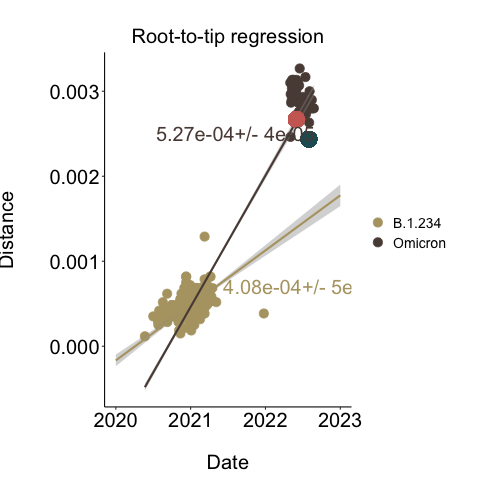

In [130]:
%%R

library(ggplot2)
library(dplyr)

data_rtt <- read.csv('augur_results/root-to-tip_complete.tsv', sep = '\t')
plot <- ggplot(data=data_rtt, aes(x=date, y=distance, 
                                 color=lineage_class)) +
  geom_point(size=4) +
  geom_smooth(data=subset(data_rtt, WHO_class == "B.1.234"),method='lm',formula=y~x, color="#B4A372", 
              se=TRUE, fullrange=TRUE) +
  geom_smooth(method='lm',formula=y~x, color="#594A42", se=TRUE) +
  scale_color_manual(values=c(B.1.234="#B4A372",Omicron="#594A42"))+
  theme(plot.title = element_text(size=20, hjust=0.5))+
  scale_x_continuous(limits=c(2020,2023)) + #, breaks=seq(2006,2018,2))+
  geom_point(aes(x=2022.413699, y=0.00267), colour="#CD6A62", size=7) + #june timepoint extracted and added manually
  geom_point(aes(x=2022.580822, y=0.002435), colour="#225C64", size=7) + #august timepoint extracted and added manually
  theme(panel.grid.major=element_line(colour=NA,size=NA))+
  theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
  theme(strip.background = element_rect(colour=NA, fill=NA))+
  labs(title="Root-to-tip regression", y="Distance", x="Date") +
  theme(axis.line.x=element_line(colour="black"))+
  theme(axis.line.y=element_line(colour="black"))+
  theme(axis.title.y=element_text(size=20, vjust=8))+
  theme(axis.title.x=element_text(size=20, vjust=-4))+
  theme(axis.text=element_text(size=20, colour="black"))+
  theme(legend.title=element_blank(),)+
  theme(panel.spacing=unit(1, "lines"))+
  theme(plot.margin=unit(c(1,1,1,1),"cm"))+
  theme(legend.key.size=unit(0.7, "cm"))+
  theme(legend.text = element_text(size=14))+
  theme(panel.background=element_rect(fill=NA))+
  theme(legend.key=element_rect(fill=NA)) +
  annotate("text",x=2021.6,y=0.0025,label=("5.27e-04+/- 4e-05"), size=7, color='#594A42') + #all Omicron and B.1.234
  annotate("text",x=2022.5,y=0.0007,label=("4.08e-04+/- 5e-05"), size=7, color='#B4A372') #B.1.234 only


ggsave('figures/rtt_regression_aligned_to_b1234.pdf', dpi=300, width = 6, height = 6, units = 'in' ) 

plot

In [134]:
!treetime --version
!iqtree --version

treetime 0.9.3
IQ-TREE multicore version 2.2.0.3 COVID-edition for Mac OS X 64-bit built Sep  5 2022
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

